# [E-11]. 어제 오른 내 주식, 과연 내일은?

시계열 예측 (Time-Series Prediction) 에서 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average)에 대해 알아보자.

## 1. 미래를 예측한다는 것은
<br/>

**🔑 미래 예측 시나리오**
- 지금까지의 주가 변화를 바탕으로 다음 주가 변동 예측
- 특정 지역의 기후데이터를 바탕으로 내일의 온도 변화 예측
- 공장 센터 데이터 변화 이력을 토대로 이상 발생 예측

**🔑 시계열(Time-Series)이란?**
$$ Y = \{Y_t : t \in T\}, where T  is the index set $$

- 매일의 주식 거래 가격을 `날짜-가격` 형태로 날짜순으로 모아둔 데이터가 바로 시계열 데이터일 것이다.
- 여기서 날짜가 인덱스(index) 역할을 하게 될 것

-> 하지만 결론적으로 정확한 **미래 예측은 불가능하다.**

🔑 필요한 **두가지 전제**
> 1. 과거의 데이터에 일정한 패턴이 발견된다. <br/>
> 2. 과거의 패턴은 미래에도 동일하게 반복될 것이다.

🔑 위 두 가지 문장을 한 문장으로 줄인다면
> **`안정적(Stationary)`** 데이터에 대해서만 미래 예측이 가능하다.

**안정적(Stationary)** 이다는 것은 **시계열 데이터의 통계적 특성이 변하지 않는다**는 뜻.
- 매우 불규칙해보이는 매일의 날씨에도 불구하고, 연 단위 기후 변화의 일정한 패턴이 유지된다면, 지구상의 일정한 기후변동 프로세스가 만들어내는 안정성(stationarity)에 의해 내일의 기온은 어느 정도 오차 범위 내에서 예측이 가능할 것

## 2. Stationary한 시계열 데이터

🔑 대전제: `과거의 패턴이 미래에도 반복될 것이다`

> 예시) 직전 5년 치 판매량 X(t-4), X(t-3), X(t-2), X(t-1), X(t)를 가지고 X(t+1)이 얼마일지 예측해보자.

이 예측이 유의미하기 위해선 **t에 무관하게** X(t-4), X(t-3), X(t-2), X(t-1), X(t)의 `평균`과 `분산`이 `일정 범위` 안에 있어야 한다.

X(t-h)와 X(t)는 **t에 무관하게** h에 대해서만 달라지는 일정한 `상관도`를 가져야 한다.

## 3. 시계열 데이터 사례 분석

### 시계열(Time Series) 생성
데이터: `Daily Minimum Temperatures in Melbourne`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


> 오늘 다룰 시계열 데이터는 시간 컬럼을 index로 하는 Series로 표현이 된다.

In [3]:
# Date 컬럼을 index로 삼아 시계열 생성해보기

# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath,
                 index_col='Date', # index로 설정
                 parse_dates=True) # 날짜 형식 데이터는 날짜로 인식
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


> 🥕 우리가 찾는 시계열은 바로 아래

In [4]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

### 시계열 안정성의 정성적 분석
시각화를 통해 안정성(Stationary) 여부를 확인해보자.

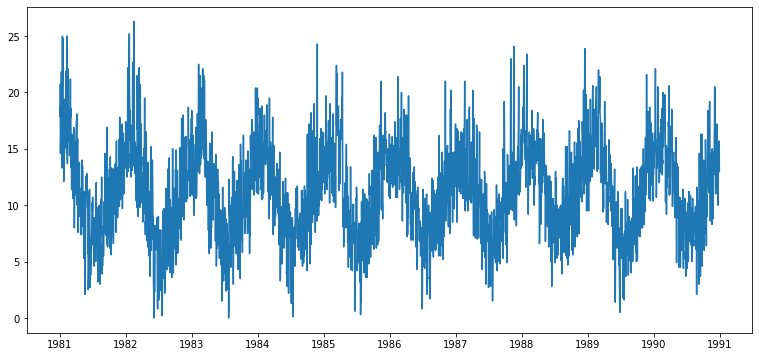

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

In [6]:
# 결측치 유무 확인
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

🥕 이 예제에서는 없지만, 만약 있다면?!
> 1. 결측치가 있는 데이터 모두 삭제(drop)
> 2. 결측치 양옆의 값들을 이용해 적절히 보간(interpolate)하여 대입 <br/>
> `ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식`

이번 예제에서는 시간을 index로 가지는 시계열 데이터이므로 삭제보다는 `보간` 방법을 선택하자 : **interpolate**

Series([], Name: Temp, dtype: float64)


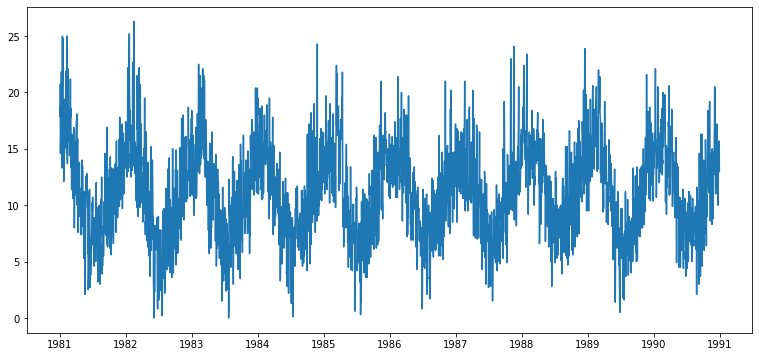

In [7]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1 = ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

아래 함수는 일정 시간 내 `구간 통계치(Rolling Statistics)`를 시각화하는 함수 <br/>

`현재 타임 스텝`부터 `window에 주어진 타임 스텝 이전` 사이
> 1. 구간의 평균(rolling mean, `이동 평균`)과
> 2. 표준편차(rolling std, `이동 표준편차`)를

원본 시계열과 함께 **시각화** 하면 더 뚜렷한 경향서을 확인할 수 있을 것이다.


🥕 이동평균(MA, Moving Average): 수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균
> ex. [2, 8, 6, 10, 4]의 이동평균은? [5, 7, 8, 7]

- `pandas.Series.rolling`: 동일한 사이즈만큼 옆으로 이동하면서 연산

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best') # 자동으로 최적의 위치에 legend 위치시킴
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False) # ensure that all figure windows are displayed and return immediately.

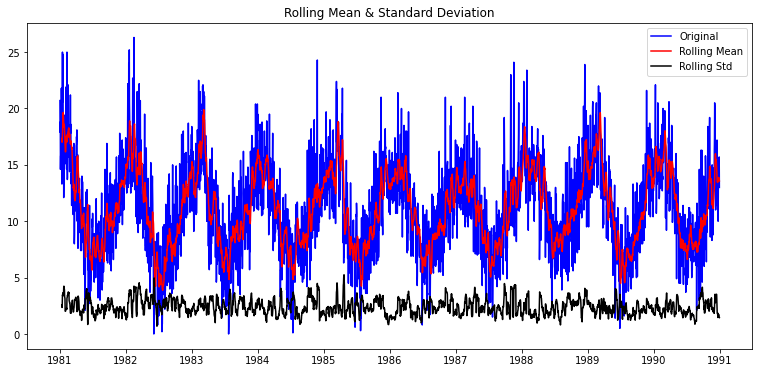

In [9]:
plot_rolling_statistics(ts1, window=12)

### 다른 데이터에 대해서도 알아보자.
`International airline passengers` 데이터셋
- 월별 항공 승객 수 (천 명 단위)의 시계열 데이터인데 기온 변화 데이터셋과는 다를까?

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


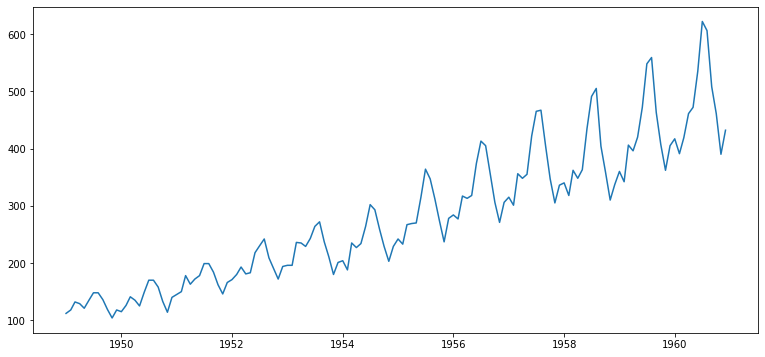

In [11]:
ts2 = df['Passengers']
plt.plot(ts2)

> - 위 온도 변화 데이터셋과는 달리 시간의 추이에 따라 시계열의 평균과 분산이 지속적으로 커지는 패턴
> - rolling statics를 추가해 시각화해보자

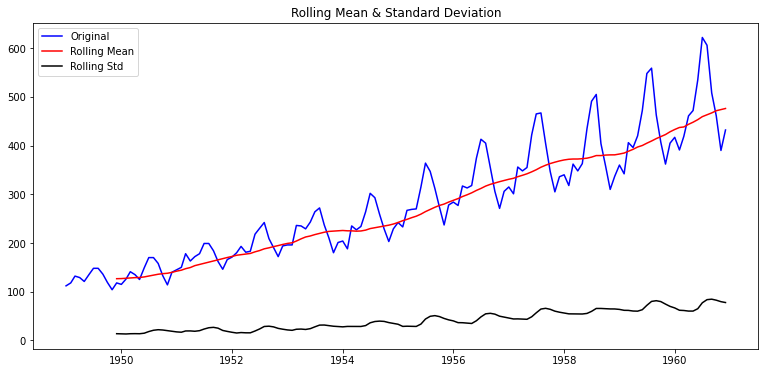

In [12]:
plot_rolling_statistics(ts2, window=12)

이렇게 시간의 추이에 따라 평균, 분산이 증가하는 패턴이라면 적어도 안정적이진 않다고 정성적인 결론을 내릴 수 있을 것이다. (시간의 흐름에 따라 그대로 유지되지 않으므로!) <br/>

> 이젠 이런 `불안정적(Non-Stationary) 시계열 데이터에 대한 시계열 분석 기법` 을 다뤄보자. <br/>
> `정량적인 방법`에 대해 알아보자.

## 4. Stationary 여부를 체크하는 통계적 방법
### Augmented Dickey-Fuller Test

> 1. `주어진 시계열 데이터가 안정적이지 않다`라는 `귀무 가설(Null Hypothesis)`를 세운 후,
> 2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에
> 3. `이 시계열 데이터가 안정적이다`라는 `대립 가설(Alternative Hypothesiss)`을 **채택**한다.

🥑 **귀무 가설**(Null Hyperthesis, $H_0: \alpha=1$) : 통계학에서 처음부터 버릴 것을 예상하는 가설 <br/>
ex) '-와 차이가 없다', '-의 효과가 없다', '-와 같다'

🥑 **대립 가설**(Alternative Hyperthesis, $H_1: \alpha\neq1$) : 귀무가설이 거짓이라면 대안적으로 참이 되는 가설 <br/>
ex) '-와 차이가 있다', '-의 효과는 있다', '-와 다르다'

🥑 **p-value** : 귀무가설이 참이라 가정했을 때, 표본으로 얻어지는 통계치(ex. 표본 평균)가 나타날 확률 <br/>
ex) p값이 낮다: 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 의미

우리가 사용할 ADF Test의 세부 알고리즘을 간단히 본 뒤, `statsmodels` 패키지에서 제공하는 `adfuller` 메서드를 이용해 손쉽게 ADF Test 결과를 이용해보자.
<br/>

🥑 **ADF 검정**: 정상성을 알아보기 위한 단위근 검정 방법
- 단위근(unit root): $x=1, y=1$ 인 해로, 시계열 자료에서 예측할 수 없는 결과를 가져올 수 있음
- **정상적**이다 = 안정적이다 = stationary = 통계적 특성(Statistical Properties)이 변하지 않음
<br/>

자료에 단위근이 존재한다는 귀무가설과 자료에 단위근이 존재하지 않아 시계열 자료가 정상성을 만족한다는 대립가설을 사용하고, 검정을 통해 귀무가설을 기각하면 정상성을 띈다고 할 수 있다.

#### 🍊 DF 검정

$$ y_t = c + \beta t + \alpha y_{t-1} + \phi \nabla y_{t-1} + e_t $$

<br/>

- $c$: 시계열 데이터의 레벨
- $\beta$: 시계열 데이터의 추세항
> - 각 파라미터를 regression으로 추정해 $\alpha$가 단위근을 가질 확률을 검정함
> - $\alpha=1$ 이면 단위근을 가지기 때문에 정상성을 띄지 않는다고 판단

<br/>

**🍊 ADF 검정**은 DF 검정에 `p lag`의 차분을 추가해 검정 능력을 더 강화시킴
- $t-p$ 시점까지의 차분 경향성을 파악할 수 있어 주기를 가진 데이터의 정상성 여부를 판단할 수 있다.

<br/>

$$ y_t = c + \beta t + \alpha y_{t-1} + \phi_1 \nabla y_{t-1} + ... + \phi_p \nabla y_{t-p}+ e_t $$

<br/>


ADF 검정의 귀무가설은 DF 검정과 귀무가설이 같으므로 **검정통계량이 Critical Value보다 작거나 p-value가 설정한 유의수준 값보다 작으면 정상적**인 시계열 데이터이다.

### statsmodels 패키지와 adfuller 메서드
`statsmodels` 패키지는 R에서 제공하는 통계검정, 시계열 분석 등의 기능을 파이썬에서도 이용할 수 있도록 하는 강력한 통계 패키지

<br/>

> `statsmodels` 패키지에서 제공하는 `adfuller` 메서드를 이용해 **주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드**

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

> 두 시계열(Time Series)에 대한 Augmented Dickey-Fuller Test를 해보자

In [14]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


> - ts1 시계열이 안정적이지 않다는 귀무가설은 **p-value가 거의 0에 가깝게** 나왔다.
> - 따라서 이 **귀무가설은 기각**되고, `이 시계열은 안정적 시계열` 이라는 **대립가설이 채택**됨

In [15]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


> - ts2 시계열이 안정적이지 않다는 귀무가설은 **p-value가 거의 1에 가깝게** 나왔다.
> - 따라서 이 **귀무가설은 기각할 수 없게**되고, `이 시계열은 안정적인 시계열` 이라고 말할 수는 **없다.**

## 5. Stationary하게 만들 방법은 없을까?
위에서 안정적이지 않았던 ts2, `International airline passengers` 시계열을 더 분석해보자. 안정적이지 않은 시계열을 분석하려면 안정적으로 바꾸어야 한다.

> 1. 정성적인 분석을 통해 보다 안정적(stationary)인 특성을 가지도록 **기존의 시계열 데이터를 가공/변형** 하는 시도
> 2. **시계열 분해(Time Series decomposition)** 기법을 적용

### 1. 보다 Stationary한 시계열로 가공하기
### 1-1. 로그함수 변환
이 시계열은 시간 추이에 따라 분산이 점점 커졌다.
> 로그함수로 변환을 해주자.

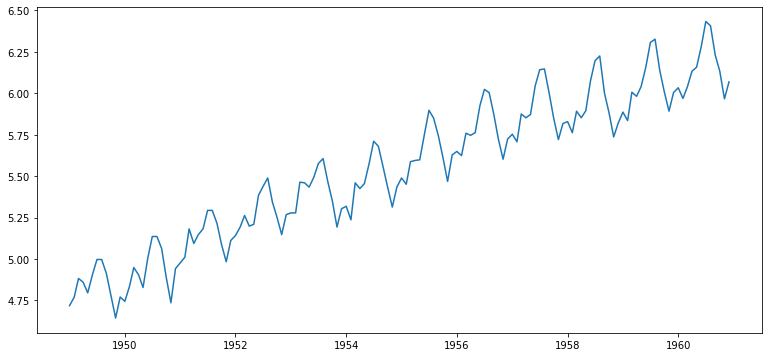

In [16]:
ts_log = np.log(ts2)
plt.plot(ts_log)

> 로그 변환의 효과를 ADF Test를 통해 확인해보자

In [17]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


> p-value가 0.99에서 0.42로 무려 절반 이상 줄었다.

### 1-2. Moving average 제거 - 추세(Trend) 상쇄하기
`추세(trend)`: 위와 같이 시간 추이에 따라 나타나는 평균값 변화
- 이 변화량을 제거해주기 위해 거꾸로 Moving Average, 즉 rolling mean을 구해서 `ts_log`에서 빼줘보자.

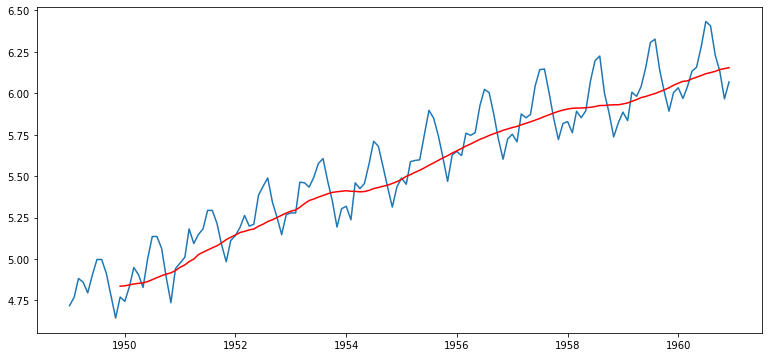

In [18]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

우리가 관심을 가진 `ts_log_moving_avg`에 거의 도달했다.
> but, 문제는 Moving Average 계산시 (windows size=12인 경우) **앞의 11개 데이터는 Moving Average가 계산되지 않으므로** `ts_log_movin_avg`에 결측치(NaN)가 발생한다는 점!

이 결측치들은 향후 Dickey-Fuller Test 시 에러를 발생시킬 것이므로 데이터셋에서 제거해주자.

In [20]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

> `ts_log_moving_avg`를 정성, 정량적으로 분석해보기

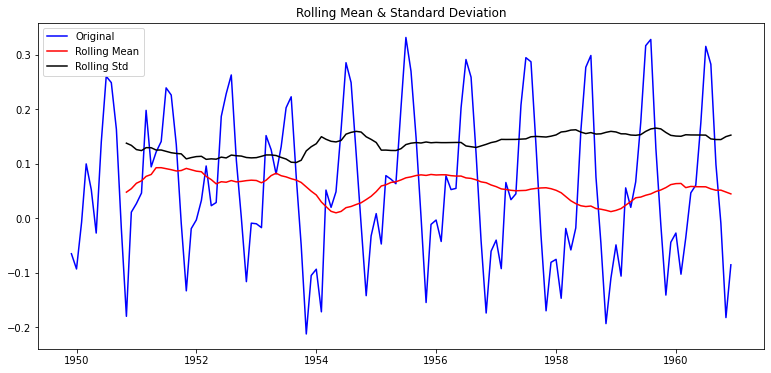

In [21]:
plot_rolling_statistics(ts_log_moving_avg)

In [22]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


p-value가 0.02 수준이 되었다. 95% 이상의 confidence로 이 time-series는 staionary하다고 할 수 있다.

> but, Moving Average를 계산하는 window=12로 정확하게 지정해주어야 한다는 문제가 있음 <br/>

🥕 만약 window=6이라면?

In [23]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

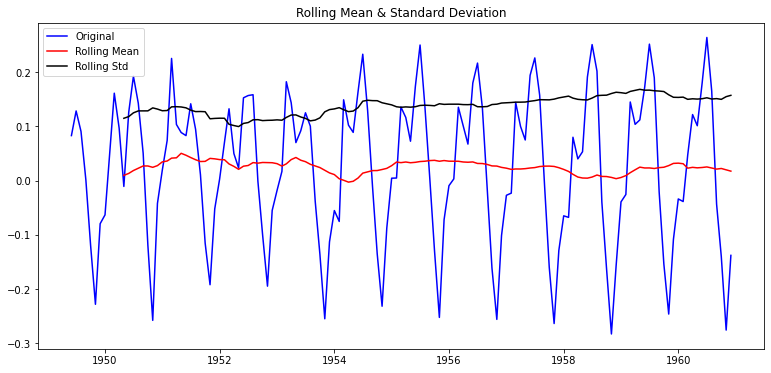

In [24]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


> 정성적으로는 별 차이가 없어보여도 Augmented Dickey-Fuller Test의 결과 p-value는 0.18 수준이라 아직도 안정적인 시계열이라 말할 수 없게 되었다.

<br/>

#### 🥕 왜 window=12 였을까?
> - 월 단위로 발생하는 시계열이므로 12개월 단위의 주기성으로 인해 window=12이지 않았을까 <br/>
> - 일단은, moving average를 고려할 때 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 걸 꼭 기억해두자!

이제 시간의 추이에 따라 평균이 증가하는 trend를 제거하였는데, 여전히 안정적인 시계열이라 하기엔 아직 걸리는 게 있다.

### 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기
Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 **패턴이 파악되지 않은 주기적 변화**는 예측에 방해가 되는 불안정성 요소이다. 이는 Moving Average 제거로는 상쇄되지 않는 효과이다.
>  이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 함

https://otexts.com/fppkr/tspatterns.html

> 🥕 **차분(Differencing)**: 마치 미분(Differentiation)처럼 시계열을 한 스텝 앞으로 shift한 시계열을 원래 시계열에서 빼주는 방법 <br/>
> -> 남는 것은 `현재 스텝 값 - 직전 스텝 값`이 되어 정확히 **이번 스텝에서 발생한 변화량을 의미**하게 됨

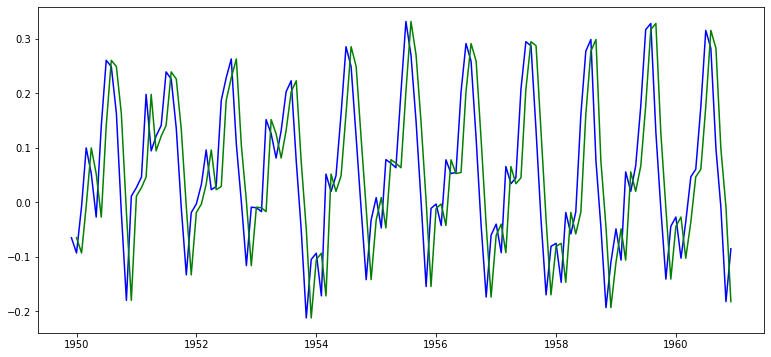

In [26]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

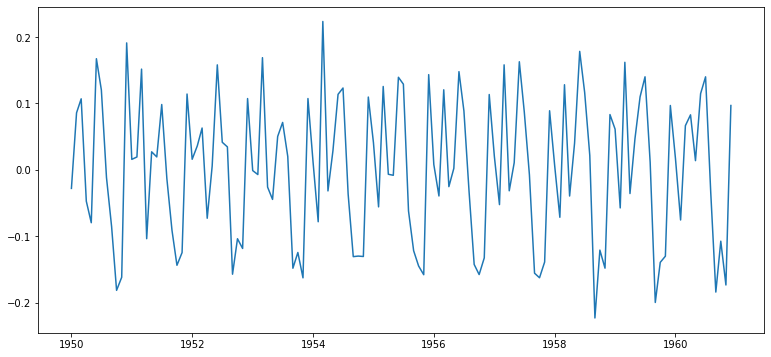

In [27]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

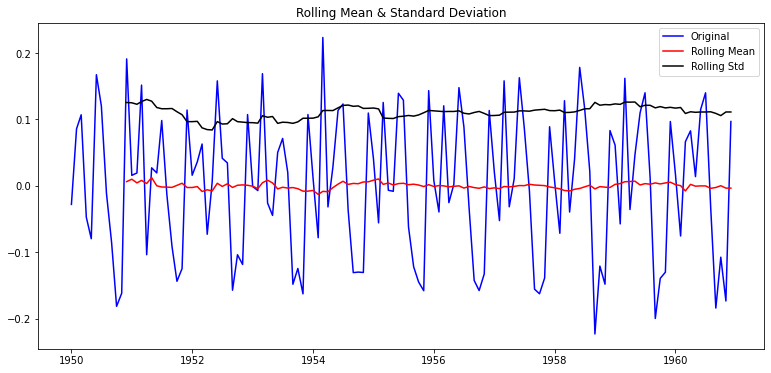

In [28]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


> p-value가 약 `0.022`에서 `0.0019`로 1/10 가량 감소했다.
> - 데이터에 따라서 2차 차분, 3차 차분, ... 을 적용하면 p-value를 더욱 낮출 수도 있을 것이다.

### 2. 시계열 분해 (Time series decomposition)

> statsmodels 라이브러리 안의 `seasonal_decompose` 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해낼 수 있는 기능이 있다.
- 위 과정을 동일하지만 훨씬 안정적으로 분리해낼 수 있다.

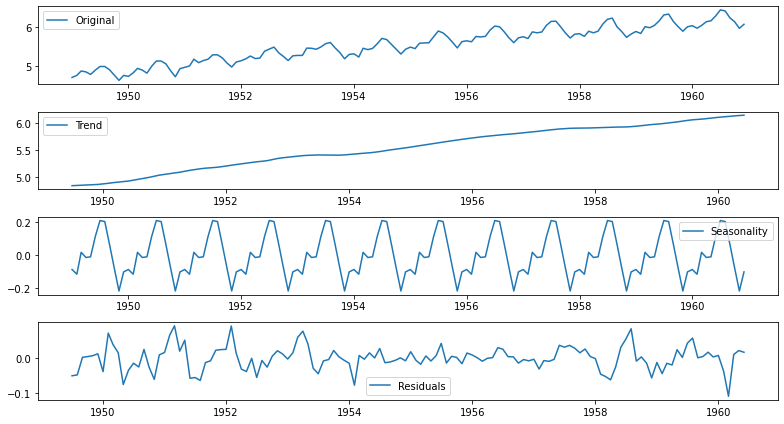

In [30]:
# 로그 변환(ts_log)부터
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11, 6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Residual`: `Original` 시계열에서 `Trend`와 `Seasonality`를 제거하고 난 나머지
- 다시 말하면 `Trend + Seasonality + Residual = Original` 이 성립한다는 뜻
- 이러한 `Decomposing`은 시계열 데이터를 이해하는 중요한 관점을 제시해줌

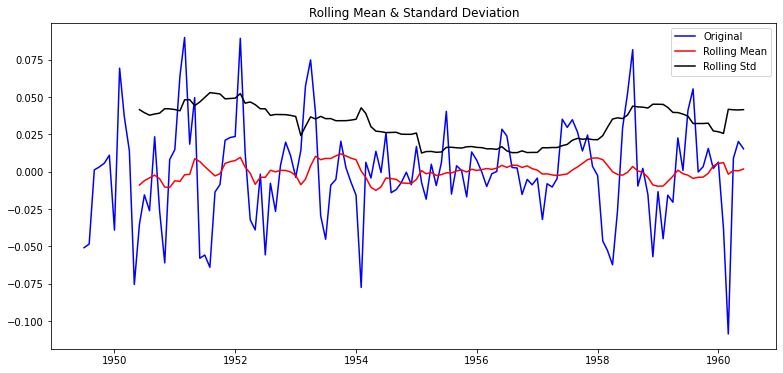

In [31]:
# Residual에 대해 안정성 여부 따지기
plt.rcParams["figure.figsize"] = (13, 6)
plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


> `Decomposing`을 통해 얻어진 `Residual`은 압도적으로 낮은 `p-value`를 보인다.

이 정도면 확실히 **예측 가능한 수준의 안정적인 시계열이 얻어졌다** 할 수 있을 것. <br/>
- 애써 `Trend`, `Seasonality`를 제거하려고 애쓰기보단 바로 `Time Series Decomposing`을 시도하는 것이 더 좋을듯하다.

## 6. ARIMA 모델의 개념
### ARIMA 모델의 정의

앞서 시계열 데이터가 `Trend`, `Seasonality`, `Residul`로 분해되어쓴데, 여기서 `Trend`와 `Seasonality`를 잘 분리해 낸 경우 `Residual`이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인했다. <br/>

`ARIMA(Autoregressive Integrated Moving Average)`를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있는데, `AR(Autoregressive)` + `I(Integrated)` + `MA(Moving Average)` 이다. <br/>

시계열 데이터 $Y = {Y_t: t \in T}$ 를 생각해봤을 때, $Y_t$를 예측하기 위해 다음 모델을 생각해볼 수 있다.

### 1-1. AR (자기회귀, Autoregressive)
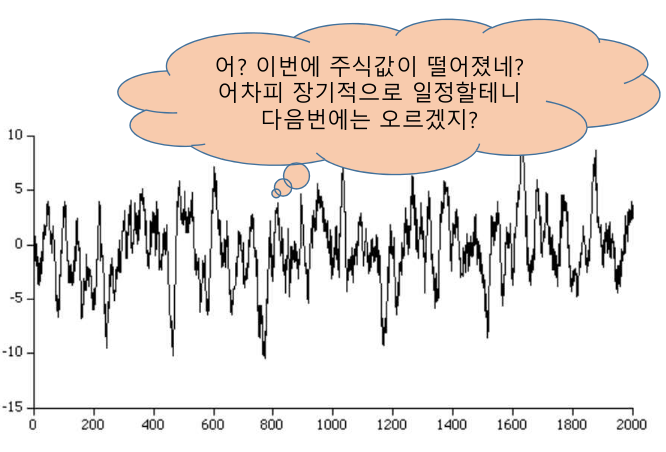
<br/>

- 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
- $Y_t$가 이전 p개의 데이터 $Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$의 가중합으로 수렴한다고 보는 모델
- $Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + e_t$

> - `AR`은 시계열의 `Residual`에 해당하는 부분을 모델링한다고 볼 수 있다.
> - 가중치의 크기가 1보다 작은 $Y_{t-1}, Y_{t-2}, ..., Y_{t-p}$의 가중합으로 수렴하는 자기회귀 모델과 안정적 시계열은 통계학적으로 동치
> - 주식값이 항상 일정한 균형 수준을 유지할 것이라 예측하는 관점이 바로 주식 시계열을 `AR`로 모델링하는 관점

### 1-2. MA (이동평균, Moving Average)
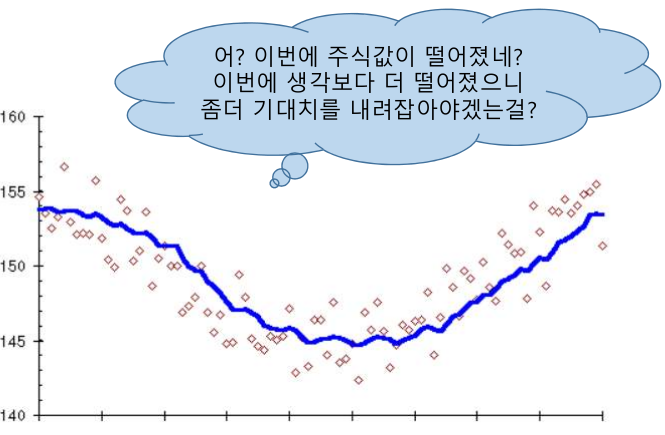
<br/>

- `MA`는 $Y_t$가 이전 q개의 예측 오차값 $e_{t-1}, e_{t-2}, ..., e_{t-q}$의 가중합으로 수렴한다고 보는 모델
- $Y_t = μ + e_t + θ_1 e_{t-1} + θ_2 e_{t-2} + ... + θ_q e_{t-q}$

> - `MA`는 시계열의 `Trend`에 해당하는 부분을 모델링한다고 볼 수 있음
> - 예측오차값 $e_{t-1}$이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻. 다음 $Y_t$ 예측 시에는 예측치를 올려잡게 됨
> - 주식값이 최근의 증감 패턴을 지속할 것이라 보는 관점은 `MA`로 모델링하는 관점이라고 할 수 있음

### 1-3. I(차분 누적, Integration)
- `I`: $Y_t$이 이전 데이터와 $d$차 차분의 누적(integration) 합이라고 보는 모델
> - `I`는 `Seasonality`에 해당하는 부분을 모델링한다.

<br/>
`ARIMA`는 위 3가지 모델을 모두 고려해 AR, MA 두 모델 사이에서 적정 수준을 찾아간다.

### ARIMA 모델의 모수 p, q, d
ARIMA를 효과적으로 활용하기 위해선 모수(parameter)를 잘 설정해야 하는데,
- `p`: 자귀 회귀 모형(AR)의 시차
- `q`: 차분 누적(I) 횟수
- `d`: 이동평균 모형(MA)의 시차

보통 `p + q < 2`, `p * q = 0`을 사용하는데 이 이유는 많은 시계열 데이터가 보통 `AR`이나 `MA` 중 하나의 경향만 가지기 때문이다.

<br/>

적절한 모수 `p`, `q`, `d`를 찾기 위한 과정으로는

1. `ACF`
> - 시차(lag)에 다른 관측치들 사이의 관련성을 측정하는 함수
> - 주어진 시계열의 현재 값이 과거 값들과 어떤 상관관계인지 설명
> - ACF plot에서 X축은 상관계수, y축은 시차 수

<br/>

2. `PACF`
> - **다른 관측치의 영향력을 배제**하고 두 시차의 관측치 간 관련성을 측정하는 함수
> - k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 뒤 특정 두 관측치, $y_t$와 $y_{t-k}$가 얼마나 관련 있는지 나타내는 척도

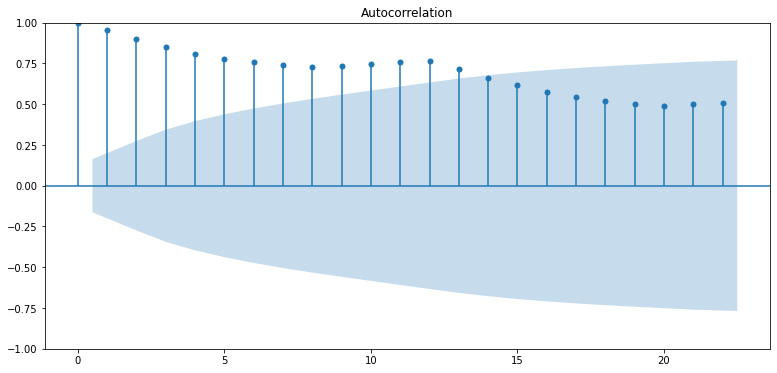

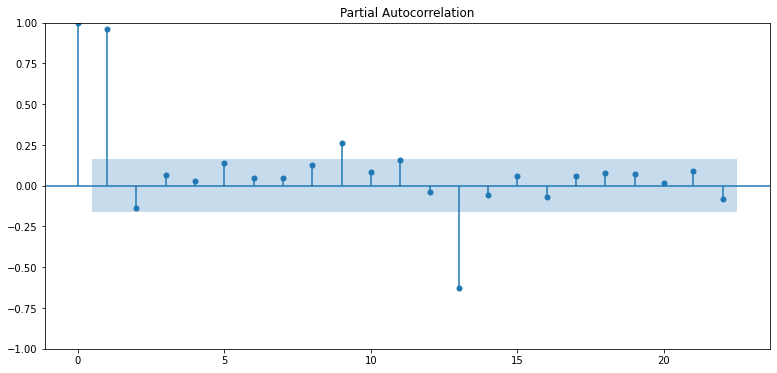

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

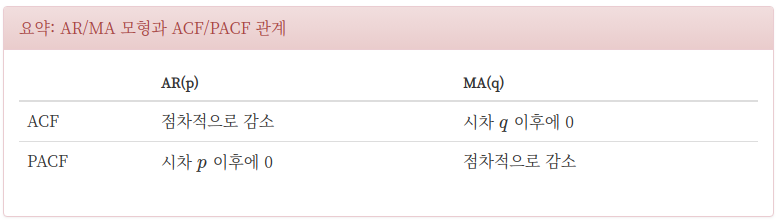

<br/>

> 위 표를 참고했을 땐 위 그래프 `PCAF`에서 `p`가 2 이상인 구간에서 거의 0에 가가워지고 있으므로, `p=1`이 적합해 보인다.
> - `PCAF`가 0이란 의미는 현재 데이터와 `p` 시점 떨어진 이전의 데이터는 상관도가 0 (아무 상관 없는 데이터), 즉 고려할 필요가 없다는 뜻이다.

> `ACF`는 점차적으로 감소하고 있어 `AR(1)` 모델과 유사한데, `q`에 대해서는 적합한 값이 없어 보인다. 이럴 경우 `q=0`을 둔다.

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


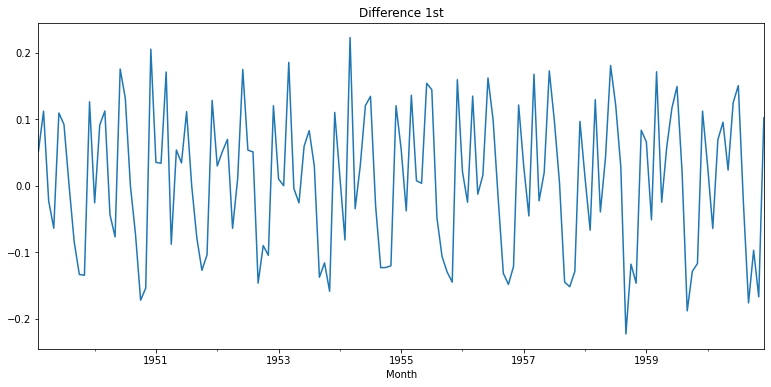

In [34]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


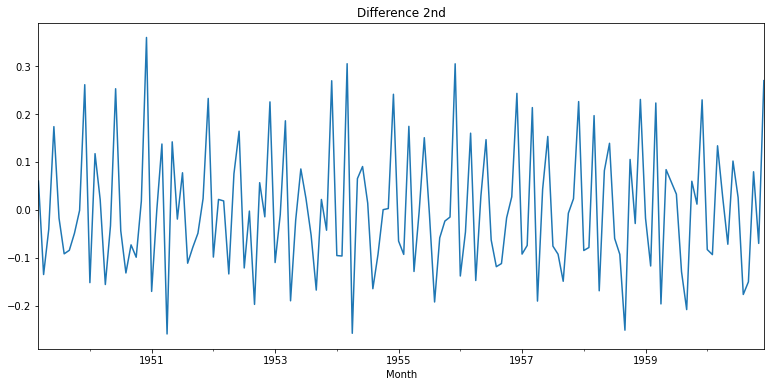

In [35]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

> 애매하지만 `d=1`로 시도를 해보고 바꿔가보자!

### 학습 데이터 분리

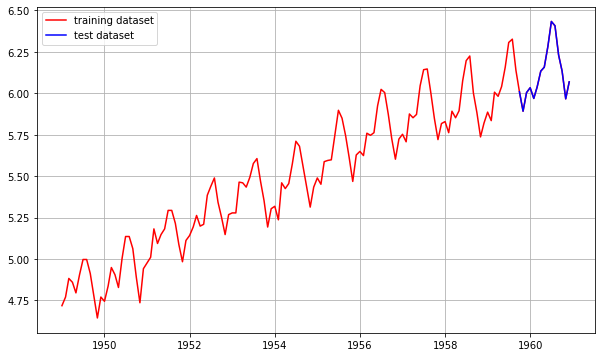

In [36]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [37]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## 7. ARIMA 모델 훈련과 추론

In [38]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.951
Date:                Thu, 17 Feb 2022   AIC                           -409.902
Time:                        14:15:35   BIC                           -367.121
Sample:                    01-01-1949   HQIC                          -392.520
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2752      0.081     -3.387      0.001      -0.434      -0.116
ar.L2         -0.0124      0.109     -0.114      0.909      -0.225       0.200
ar.L3          0.0002      0.046      0.005      0.9

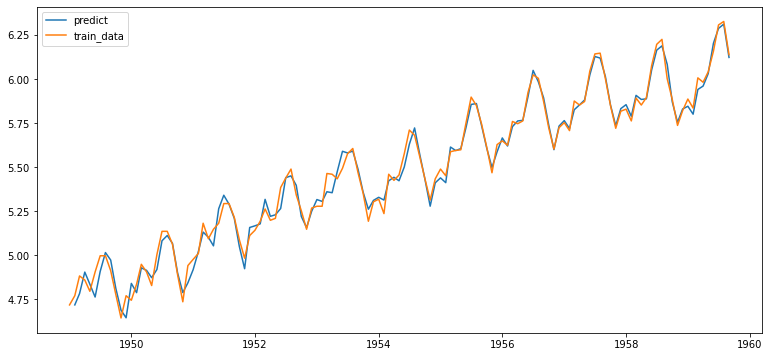

In [39]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

> `forecast()` 메소드를 이용해 테스트 데이터 구간의 데이터를 예측해보기

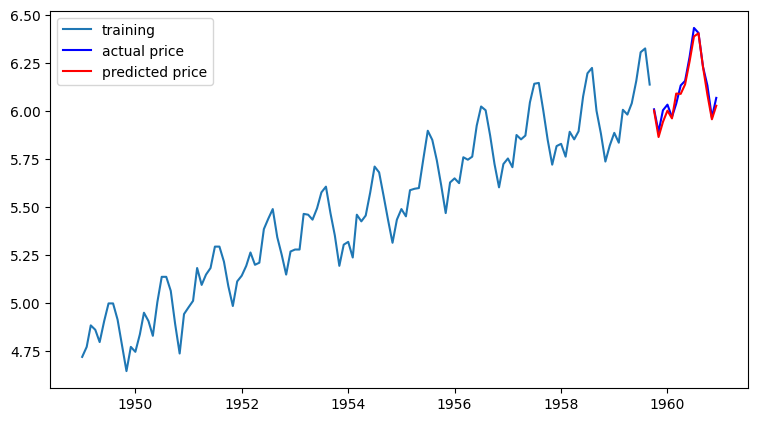

In [40]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

> 위에서 로그 변환을 했으므로 오차를 계산하기 위해선 `np.exp()`를 취하자.

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  231.97320956929948
MAE:  12.424959605677085
RMSE:  15.230666747365314
MAPE: 2.74%


## 11-9. 프로젝트: 주식 예측에 도전해보기

# 🧤 1. Samsung

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [82]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [83]:
# 로그 변환 시도 
ts_log = np.log(ts)

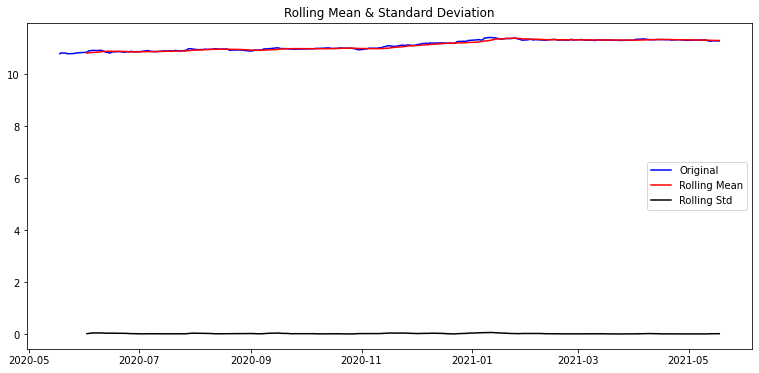

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


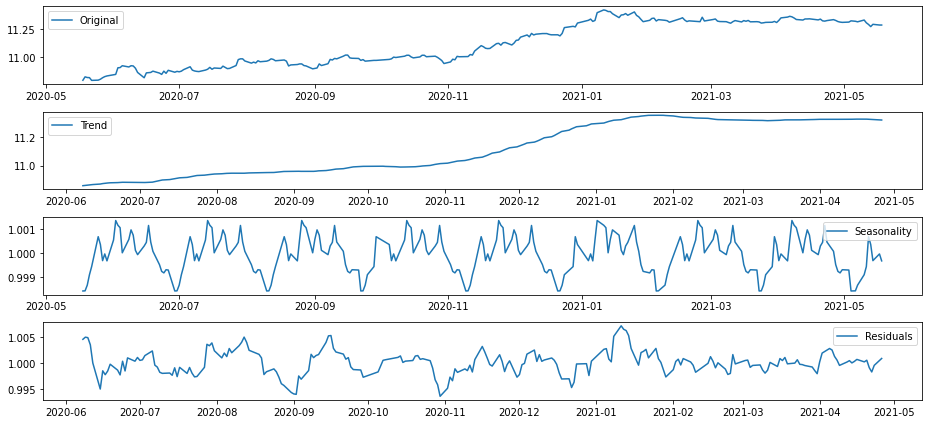

In [84]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [85]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


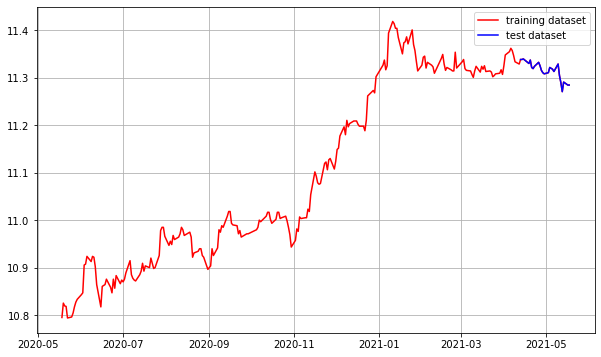

In [86]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

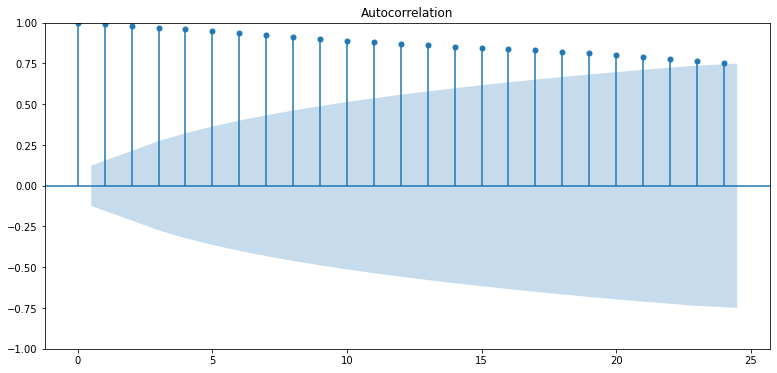

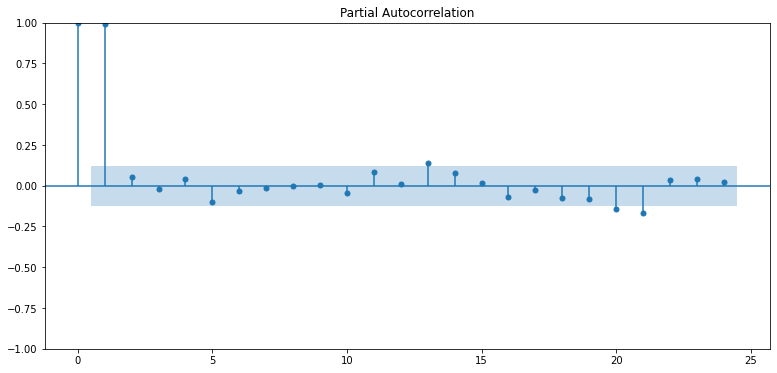

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

> - PACF 함수를 통해 p가 2 이상인 경우 급속도로 감소해 p=1로 두었다.
> - q는 크게 판별할 수 없어 1로 두자.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


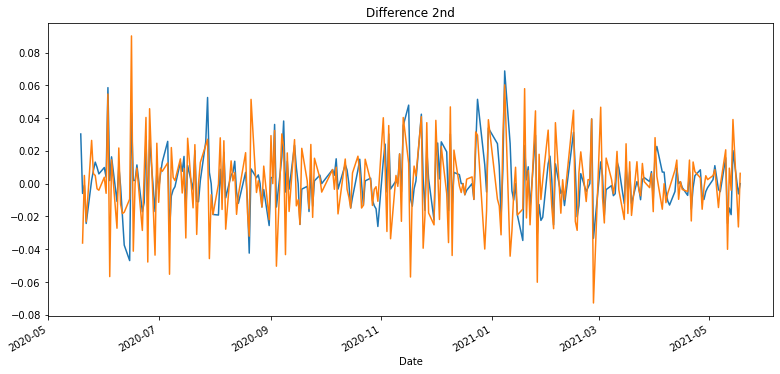

In [88]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

> 1차 차분을 이용하자.

In [107]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Thu, 17 Feb 2022   AIC                          -1160.979
Time:                        14:32:25   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

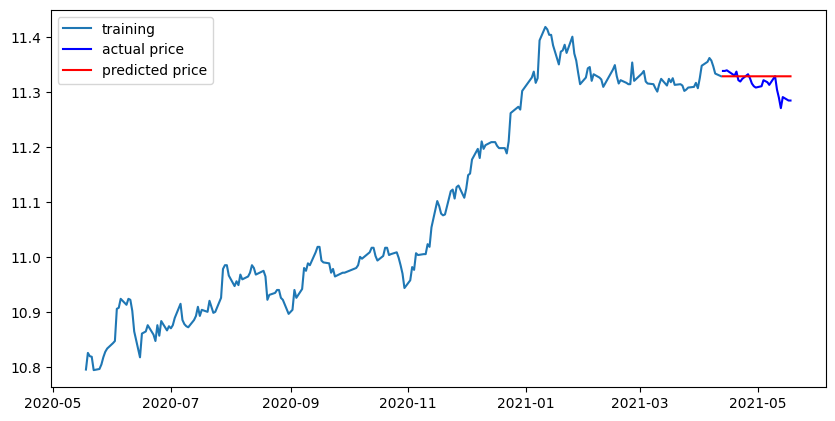

In [108]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480580.457711579
MAE:  1403.0537770723201
RMSE:  1865.631383127862
MAPE: 1.74%


# 🧤 2. Microsoft

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath2 = os.getenv('HOME') + '/aiffel/stock_prediction/data/MSFT.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2021-02-17    244.199997
2021-02-18    243.789993
2021-02-19    240.970001
2021-02-22    234.509995
2021-02-23    233.270004
Name: Close, dtype: float64

In [111]:
# 결측치 처리
ts2 = ts2.interpolate(method='time')
ts2[ts2.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

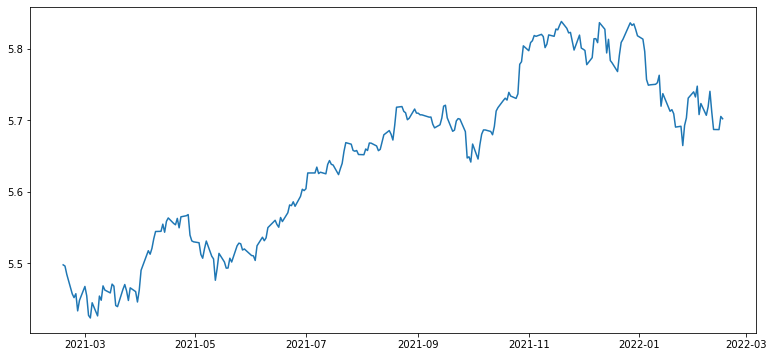

In [112]:
# 로그 변환 시도 
ts2_log = np.log(ts2)
plt.plot(ts2_log)

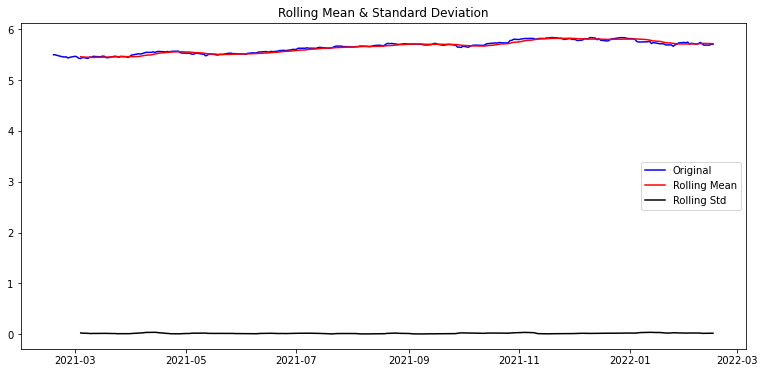

Results of Dickey-Fuller Test:
Test Statistic                  -1.295236
p-value                          0.631349
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


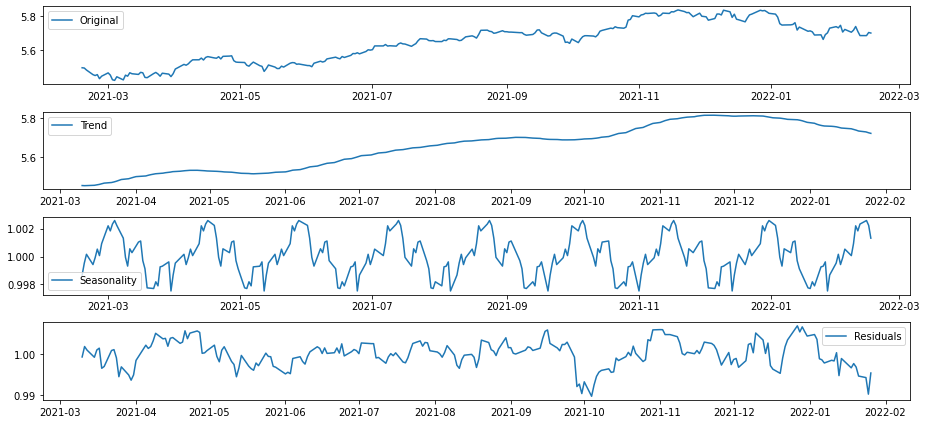

In [113]:
# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts2_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

> Trend와 계절성이 나타난 그래프이고, 이를 제거한 Residuals를 확인할 수 있다.

In [114]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.912155
p-value                          0.000033
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


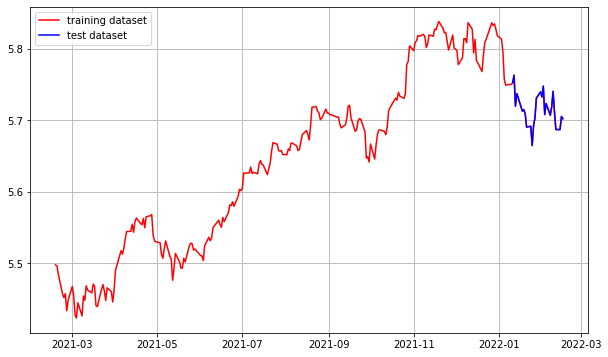

In [115]:
train_data, test_data = ts2_log[:int(len(ts2_log)*0.9)], ts2_log[int(len(ts2_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

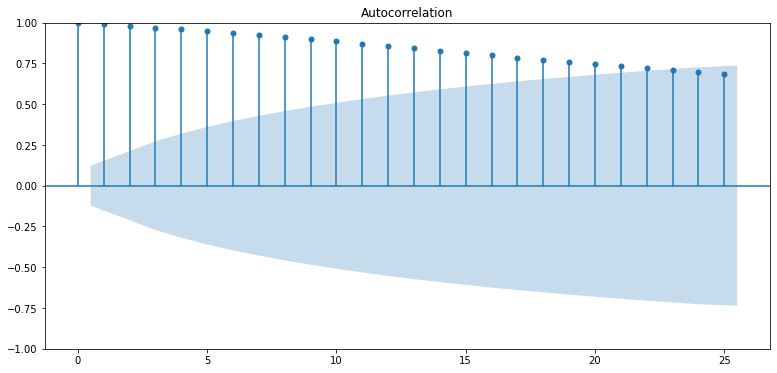

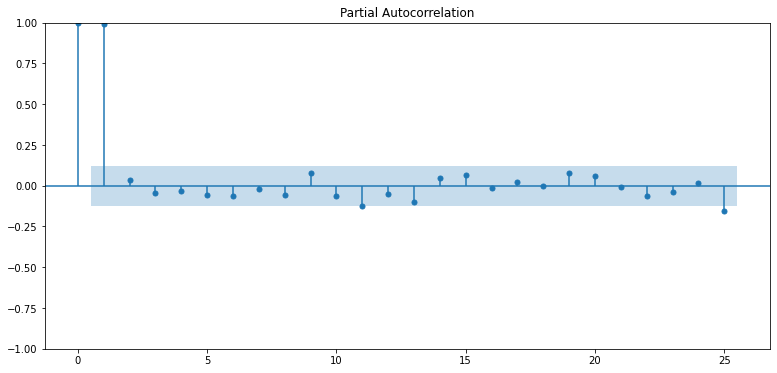

In [116]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

> - ACF는 감소하는 경향을 보여 AR(1) 모델과 유사하다고 판단하였다.
> - PACF에서 p가 2 이상인 경우 거의 0에 가까워 p=1라고 판단하였다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.662600e+01
p-value                        1.681986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.414691e+00
p-value                        6.985281e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


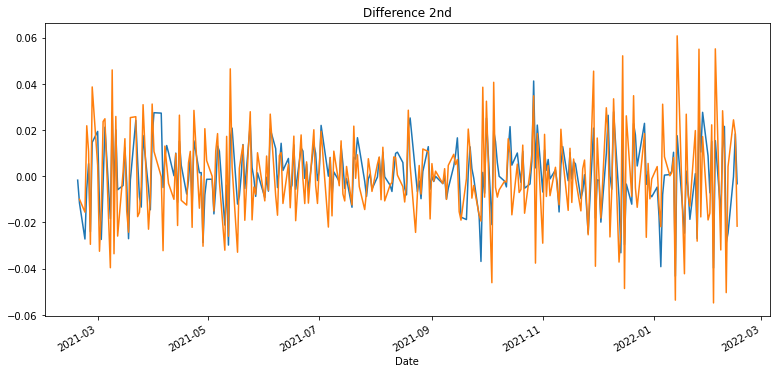

In [117]:
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

> 2차 미분이 더 안정화된 상태라 판단해 d=2라 둔다.
> - 하지만 d=0으로 둔 경우 성능이 더 좋게 나옴

In [133]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1)) # p, d, q
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 662.343
Date:                Thu, 17 Feb 2022   AIC                          -1316.686
Time:                        14:35:07   BIC                          -1302.968
Sample:                             0   HQIC                         -1311.151
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6387      0.070     80.709      0.000       5.502       5.776
ar.L1          0.9923      0.006    153.939      0.000       0.980       1.005
ma.L1          0.0233      0.066      0.351      0.7

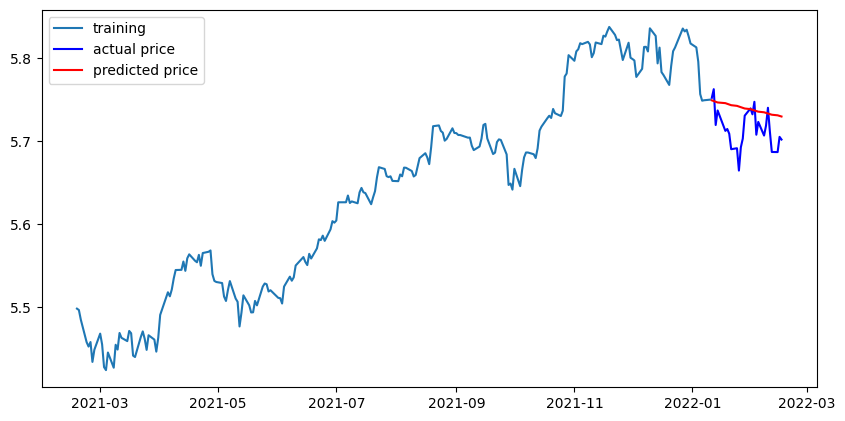

In [134]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [135]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  98.07705057614238
MAE:  8.23364179021214
RMSE:  9.903385813757959
MAPE: 2.75%


# 🧤 3. Kakao

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath3 = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df3 = pd.read_csv(dataset_filepath3, index_col='Date', parse_dates=True)
ts3 = df3['Close']

ts3.head()

Date
2021-02-17    101800.0
2021-02-18    100200.0
2021-02-19    100800.0
2021-02-22     98100.0
2021-02-23     97400.0
Name: Close, dtype: float64

In [137]:
# 결측치 처리
ts3 = ts3.interpolate(method='time')
ts3[ts3.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

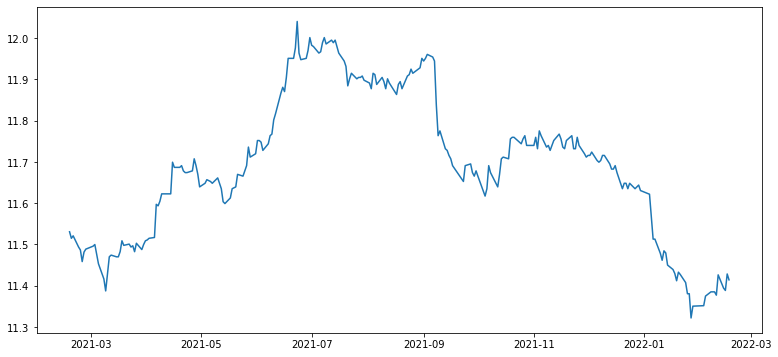

In [138]:
# 로그 변환 시도 
ts3_log = np.log(ts3)
plt.plot(ts3_log)

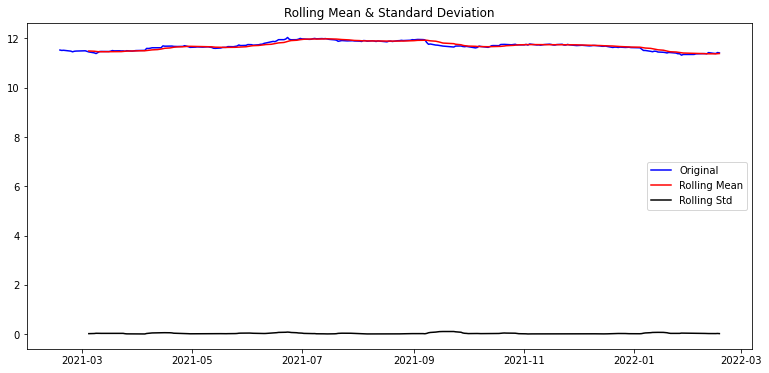

Results of Dickey-Fuller Test:
Test Statistic                  -1.490269
p-value                          0.538320
#Lags Used                       7.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


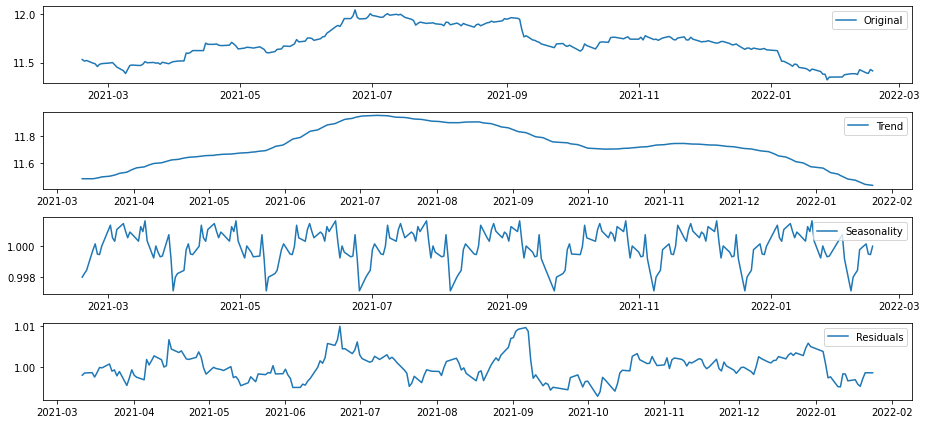

In [139]:
# 정성적 그래프 분석
plot_rolling_statistics(ts3_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts3_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts3_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts3_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [140]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.271103
p-value                          0.000498
#Lags Used                       3.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


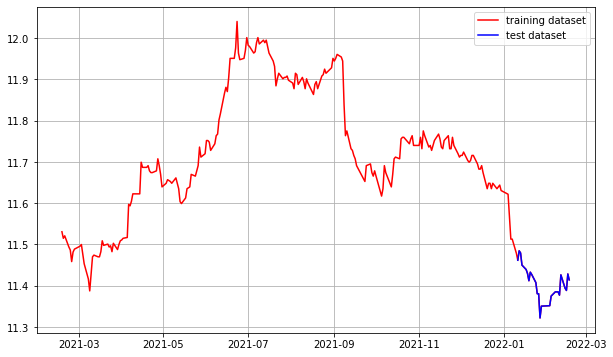

In [141]:
train_data, test_data = ts3_log[:int(len(ts3_log)*0.9)], ts3_log[int(len(ts3_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts3_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

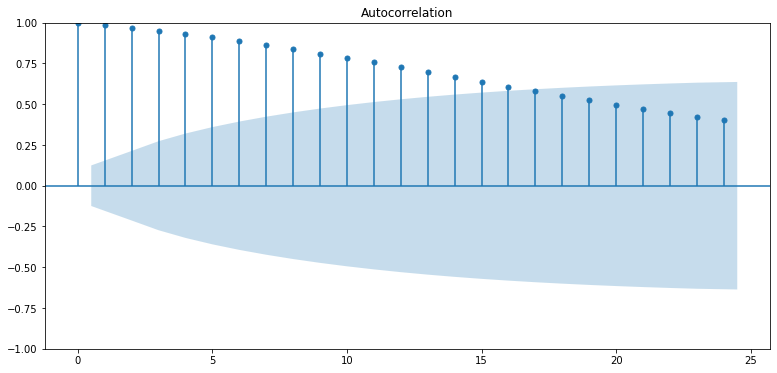

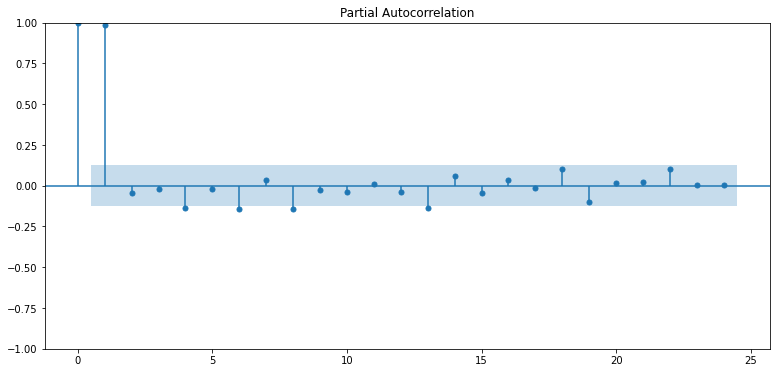

In [142]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts3_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts3_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

> 마찬가지로 p는 1, q도 1로 설정하자.

Results of Dickey-Fuller Test:
Test Statistic                -7.893234e+00
p-value                        4.379448e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.178480e+01
p-value                        1.014775e-21
#Lags Used                     5.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


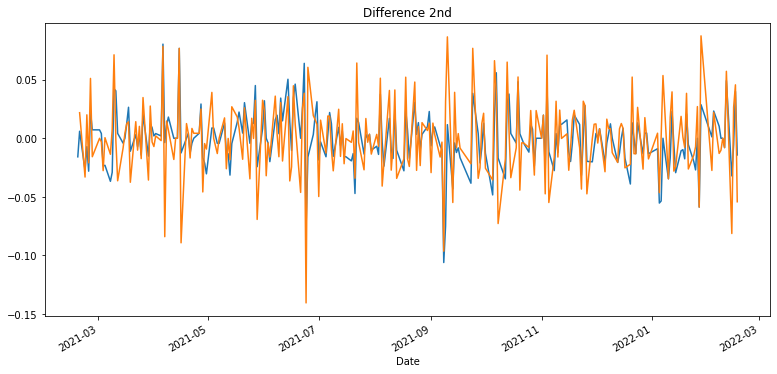

In [143]:
# 1차 차분 구하기
diff_1 = ts3_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

> d=2로 설정하자.

In [144]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 512.701
Date:                Thu, 17 Feb 2022   AIC                          -1019.402
Time:                        14:35:33   BIC                          -1009.207
Sample:                             0   HQIC                         -1015.285
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0622      0.060      1.036      0.300      -0.055       0.180
ma.L1         -0.9710      0.019    -50.030      0.000      -1.009      -0.933
sigma2         0.0006   3.44e-05     16.227      0.0

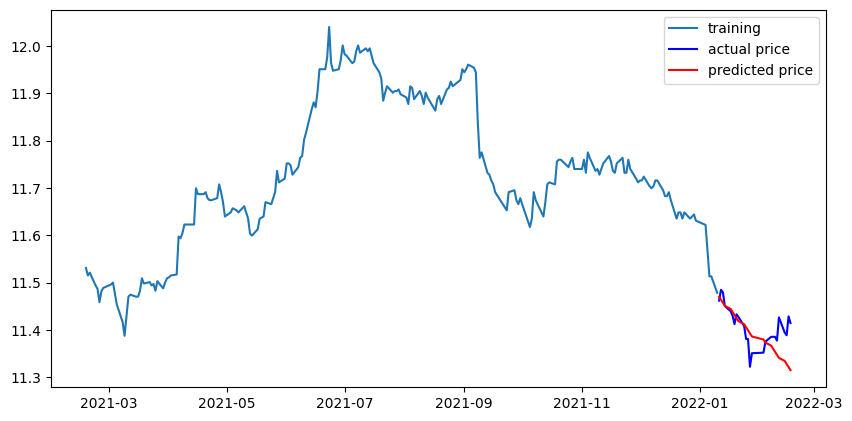

In [145]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14681501.059164992
MAE:  2815.7765790047274
RMSE:  3831.644693752931
MAPE: 3.15%


***

# 🧤 회고
- 개념이 너무 어려워 천천히 보다가 결국 노드를 완벽히 마무리 하지 못했다. 통계적 개념 부분이 굉장히 낯설고 어려워 많은 공부가 필요함을 절실히 느꼈다 .. 그리고 미리미리 하지 않은 내 자신도 반성을..
- 평소에 주식엔 큰 관심이 없지만 이번 노드를 진행하며 살짝 흥미가 생겨 좀 더 공부해본 뒤에 도전해볼까(?) 라는 생각도 들었다.
- ARIMA라는 모델에 대해 더 깊은 공부 후에 이번 플젝을 다시 꼭 발전시켜야겠다.
- 시계열 데이터를 제대로 처음 다뤄보았는데 상당히 복잡했지만 시간에 따른 변화, 안정성, 예측하는 방법 등에 대해 배울 수 있어서 재밌었다.
- ARIMA 모수를 변형하지 않아도 나쁘지 않은 성능을 보였다. 또한 조원 분들과 얘기하던 중 RMSE와 같은 오차 값이 작다고 무조건 성능이 좋다는 말을 들었는데 이에 대해서도 더 찾아봐야겠다 :)

- 첫 번째 예제에서 왜 p=14로 두었고, 왜 그 때 성능이 더 좋게 나왔는지 분석이 좀 더 필요한 것 같다.
- 3가지 모델 모두 ACF와 PCAF 모델이 비슷하게 그려졌다. 따라서 추출되는 파라미터 p, q, d도 비슷했는데 오히려 다른 값을 넣었을 때 (ex. d=0, p=14) 인 경우 성능이 더 좋게 나왔던 것 같다. 왜지?!
- auto_arima 함수로 일일이 대입해보는 게 아니라 최적의 파라미터를 추출할 수 있는 방법이 있었는데, 이보다 오히려 p=14를 대입했던 게 더 좋은 성능을 보였다.